In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']
/home/jovyan/fourier_learning_ibm


In [3]:
from pycaret.regression import RegressionExperiment
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from pycaret.regression import RegressionExperiment

from post_process import (
    extract_probs,
)

In [4]:
n_qubits = 4
n_samples = 55
backend_qpu_name = "ibm_marrakesh"

path_exact = f"results/fourier_feature_exact/{n_qubits}Q"
path_sim_noiseless = f"results/fourier_feature_sim_noiseless/{n_qubits}Q"
path_sim_noisy = f"results/fourier_feature_sim_noisy/{n_qubits}Q"
path_qpu = f"results/fourier_feature_qpu/{n_qubits}Q"

## Plot probability

In [5]:
# Load the data as a json file
with open(f"{path_exact}/probs_phase0.json", "r") as f:
    probs_phase0_exact = json.load(f)
with open(f"{path_exact}/probs_phase1.json", "r") as f:
    probs_phase1_exact = json.load(f)
with open(f"{path_exact}/probs_phase2.json", "r") as f:
    probs_phase2_exact = json.load(f)
with open(f"{path_exact}/probs_phase3.json", "r") as f:
    probs_phase3_exact = json.load(f)

In [6]:
with open(f"{path_sim_noiseless}/probs_phase0.json", "r") as f:
    probs_phase0_sim_noiseless = json.load(f)
with open(f"{path_sim_noiseless}/probs_phase1.json", "r") as f:
    probs_phase1_sim_noiseless = json.load(f)
with open(f"{path_sim_noiseless}/probs_phase2.json", "r") as f:
    probs_phase2_sim_noiseless = json.load(f)
with open(f"{path_sim_noiseless}/probs_phase3.json", "r") as f:
    probs_phase3_sim_noiseless = json.load(f)

In [7]:
with open(f"{path_sim_noisy}/probs_phase0.json", "r") as f:
    probs_phase0_sim_noisy = json.load(f)
with open(f"{path_sim_noisy}/probs_phase1.json", "r") as f:
    probs_phase1_sim_noisy = json.load(f)
with open(f"{path_sim_noisy}/probs_phase2.json", "r") as f:
    probs_phase2_sim_noisy = json.load(f)
with open(f"{path_sim_noisy}/probs_phase3.json", "r") as f:
    probs_phase3_sim_noisy = json.load(f)

In [8]:
with open(f"{path_qpu}/probs_phase0.json", "r") as f:
    probs_phase0_qpu = json.load(f)
with open(f"{path_qpu}/probs_phase1.json", "r") as f:
    probs_phase1_qpu = json.load(f)
with open(f"{path_qpu}/probs_phase2.json", "r") as f:
    probs_phase2_qpu = json.load(f)
with open(f"{path_qpu}/probs_phase3.json", "r") as f:
    probs_phase3_qpu = json.load(f)

In [9]:
# Dummy data
probs_phase0_qpu = probs_phase0_exact
probs_phase1_qpu = probs_phase1_exact
probs_phase2_qpu = probs_phase2_exact
probs_phase3_qpu = probs_phase3_exact

In [10]:
probs_phase0_exact = extract_probs(probs_phase0_exact, probs_phase0_qpu)
probs_phase1_exact = extract_probs(probs_phase1_exact, probs_phase1_qpu)
probs_phase2_exact = extract_probs(probs_phase2_exact, probs_phase2_qpu)
probs_phase3_exact = extract_probs(probs_phase3_exact, probs_phase3_qpu)

probs_phase0_sim_noiseless = extract_probs(probs_phase0_sim_noiseless, probs_phase0_qpu)
probs_phase1_sim_noiseless = extract_probs(probs_phase1_sim_noiseless, probs_phase1_qpu)
probs_phase2_sim_noiseless = extract_probs(probs_phase2_sim_noiseless, probs_phase2_qpu)
probs_phase3_sim_noiseless = extract_probs(probs_phase3_sim_noiseless, probs_phase3_qpu)

probs_phase0_sim_noisy = extract_probs(probs_phase0_sim_noisy, probs_phase0_qpu)
probs_phase1_sim_noisy = extract_probs(probs_phase1_sim_noisy, probs_phase1_qpu)
probs_phase2_sim_noisy = extract_probs(probs_phase2_sim_noisy, probs_phase2_qpu)
probs_phase3_sim_noisy = extract_probs(probs_phase3_sim_noisy, probs_phase3_qpu)

# probs_phase0_qpu = extract_probs(probs_phase0_qpu, probs_phase0_qpu)
# probs_phase1_qpu = extract_probs(probs_phase1_qpu, probs_phase1_qpu)
# probs_phase2_qpu = extract_probs(probs_phase2_qpu, probs_phase2_qpu)
# probs_phase3_qpu = extract_probs(probs_phase3_qpu, probs_phase3_qpu)

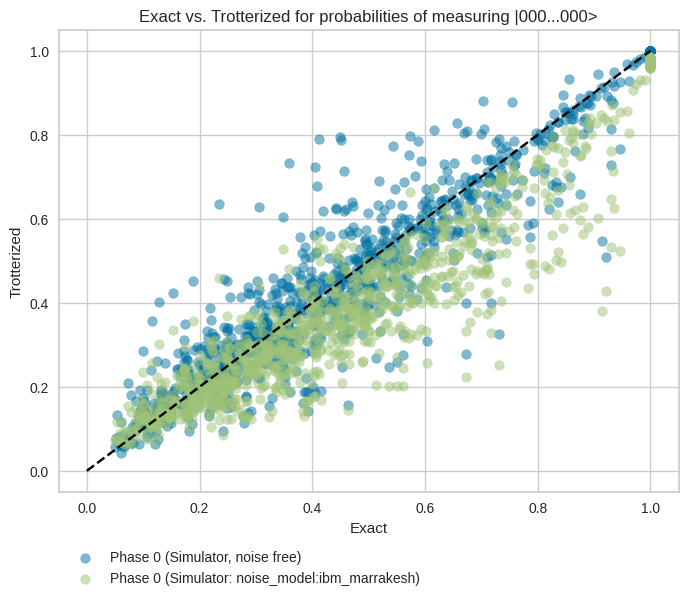

In [11]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact,
    probs_phase0_sim_noiseless,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact,
    probs_phase0_sim_noisy,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase0_exact,
#     probs_phase0_qpu,
#     label=f"Phase 0 (QPU: {backend_qpu_name})",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

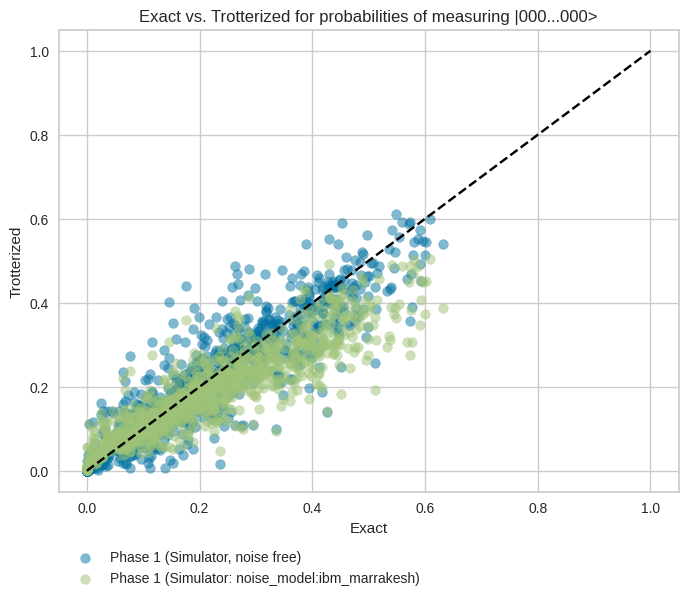

In [12]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase1_exact,
    probs_phase1_sim_noiseless,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact,
    probs_phase1_sim_noisy,
    label=f"Phase 1 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase1_exact,
#     probs_phase1_qpu,
#     label=f"Phase 1 (QPU: {backend_qpu_name})",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

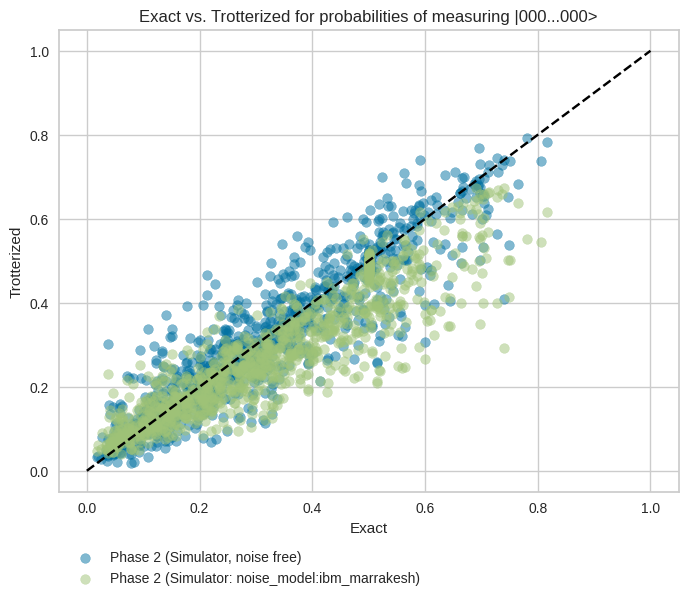

In [13]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase2_exact,
    probs_phase2_sim_noiseless,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact,
    probs_phase2_sim_noisy,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase2_exact,
#     probs_phase2_qpu,
#     label=f"Phase 2 (QPU: {backend_qpu_name})",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

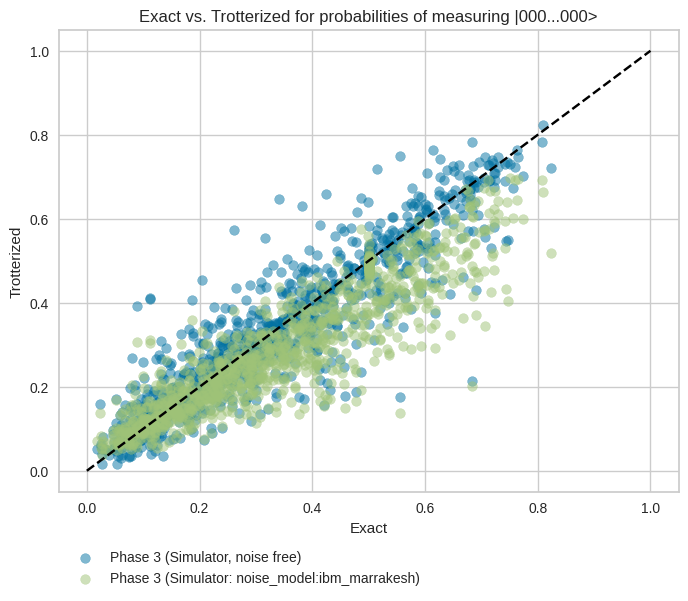

In [14]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase3_exact,
    probs_phase3_sim_noiseless,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact,
    probs_phase3_sim_noisy,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase3_exact,
#     probs_phase3_qpu,
#     label=f"Phase 3 (QPU: {backend_qpu_name})",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

## Regression

In [15]:
feature_exact_df = pd.read_json(f"{path_exact}/features.json")
feature_sim_noiseless_df = pd.read_json(f"{path_sim_noiseless}/features.json")
feature_sim_noisy_df = pd.read_json(f"{path_sim_noisy}/features.json")
# feature_qpu_df = pd.read_json(f"{path_qpu}/features.json")

### Feature check

In [16]:
print("Exact")
display(feature_exact_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_14 Im,f_15 Re,f_15 Im,f_16 Re,f_16 Im,f_17 Re,f_17 Im,f_18 Re,f_18 Im,expected_value
0,0,1,0.560687,0.420610,-0.004403,0.161817,-0.059900,-0.039643,-0.271602,0.206875,...,-0.678152,0.369094,-0.270008,0.133341,-0.063803,0.217882,-0.139135,0.444786,0.274679,5.547457
1,1,1,0.659937,0.510626,0.010218,0.488936,-0.286929,0.028484,-0.046904,-0.320783,...,-0.657615,0.395262,-0.163542,0.060216,0.399626,-0.553024,0.448836,-0.809490,0.015124,3.841905
2,2,1,0.786771,-0.242274,0.321462,-0.343534,-0.029329,-0.292498,-0.033683,-0.209428,...,0.014087,-0.156450,0.108880,-0.219413,0.192764,0.020689,0.092465,0.344706,-0.210200,1.129636
3,3,1,0.532348,0.345389,-0.228494,-0.036971,-0.310471,-0.712980,0.189510,-0.733352,...,0.241268,0.023086,0.325295,0.139495,0.221252,0.259271,0.150223,0.165745,0.164318,4.731457
4,4,1,0.896922,-0.276852,0.648533,-0.508849,0.381886,-0.626635,0.188313,-0.578558,...,-0.378536,-0.247978,-0.220286,-0.212152,-0.104582,-0.187853,-0.093106,-0.173653,-0.155228,0.852425
5,5,1,0.543823,-0.406658,-0.018078,-0.098544,-0.025449,0.128316,-0.177597,-0.120177,...,0.654129,0.290107,0.000532,-0.197580,-0.077482,-0.136399,0.146674,0.060063,-0.061320,0.828226
6,6,1,0.705606,0.276342,0.271425,0.124807,0.193243,-0.033918,0.131369,0.233588,...,-0.426300,0.023777,-0.520185,0.489157,-0.125354,0.519695,0.347793,0.409986,0.349977,3.697788
7,7,1,0.863673,-0.145024,0.554199,-0.304717,0.279728,-0.416050,0.178488,-0.375409,...,-0.012776,0.447312,-0.063669,0.615878,-0.140069,0.636338,-0.244339,0.468020,-0.390714,1.258985
8,8,1,0.705002,0.477656,0.083901,0.546686,-0.311094,0.156715,-0.137908,-0.343958,...,0.381574,0.054260,0.421317,-0.114499,0.174185,0.040231,-0.117316,0.320835,-0.210460,3.279570
9,9,1,0.816539,0.064271,0.414581,0.198627,0.098563,0.337863,0.052650,0.328533,...,-0.277918,0.662827,-0.109879,0.945172,0.006338,0.903950,0.063562,0.546511,0.149703,1.577586


In [17]:
print("Simulator (noise free)")
display(feature_sim_noiseless_df)

Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_14 Im,f_15 Re,f_15 Im,f_16 Re,f_16 Im,f_17 Re,f_17 Im,f_18 Re,f_18 Im,expected_value
0,0,1,0.559947,0.407132,0.036789,0.127444,-0.098054,-0.033022,-0.303064,0.164285,...,-0.690341,0.339422,-0.305664,0.174201,-0.055758,0.249396,-0.080039,0.468196,0.229590,5.547457
1,1,1,0.692743,0.509144,0.137678,0.386567,-0.301019,0.103584,-0.265812,-0.234759,...,-0.559732,0.292897,-0.469406,0.345415,0.081826,-0.158607,0.440517,-0.746004,0.394469,3.841905
2,2,1,0.758867,-0.240900,0.312844,-0.171965,-0.041572,-0.249366,-0.143930,-0.319206,...,-0.029909,0.073431,0.079258,-0.185783,0.204221,-0.146012,0.096527,0.105064,-0.168316,1.129636
3,3,1,0.543812,0.286092,-0.077930,-0.173575,-0.296312,-0.706375,-0.063154,-0.737831,...,0.189904,0.000597,0.386946,0.135512,0.285520,0.273575,0.237291,0.267123,0.160038,4.731457
4,4,1,0.876439,-0.303968,0.621926,-0.373682,0.398266,-0.596260,0.267088,-0.527982,...,-0.359158,-0.109983,-0.228432,-0.078802,-0.145565,-0.044410,-0.020807,-0.062182,-0.086400,0.852425
5,5,1,0.547740,-0.389446,0.015685,-0.088297,-0.079811,0.123514,-0.207041,-0.078080,...,0.667988,0.295294,0.004951,-0.207291,-0.061401,-0.151579,0.103868,0.046993,-0.034697,0.828226
6,6,1,0.674179,0.316522,0.200297,0.186245,0.135157,-0.026459,0.195120,0.243159,...,-0.352270,-0.092773,-0.529297,0.479310,-0.267363,0.560239,0.288822,0.354053,0.429175,3.697788
7,7,1,0.844791,-0.108400,0.520776,-0.147985,0.245230,-0.341895,0.082656,-0.358387,...,0.201309,0.263735,0.118663,0.431500,-0.059605,0.586797,-0.191943,0.499332,-0.223326,1.258985
8,8,1,0.706850,0.438702,0.163075,0.393035,-0.286849,0.206849,-0.251729,-0.096278,...,0.025448,0.347119,0.373982,-0.045350,0.408489,-0.133295,0.221235,0.052203,-0.076568,3.279570
9,9,1,0.806190,0.010056,0.332599,0.058008,0.037105,0.262187,-0.036029,0.339556,...,-0.506007,0.393067,-0.211268,0.743825,-0.007482,0.872421,0.028808,0.675195,-0.020317,1.577586


In [18]:
print("Simulator (noisy)")
display(feature_sim_noisy_df)

Simulator (noisy)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_14 Im,f_15 Re,f_15 Im,f_16 Re,f_16 Im,f_17 Re,f_17 Im,f_18 Re,f_18 Im,expected_value
0,0,0.976562,0.536754,0.366397,0.068647,0.134995,-0.104079,-0.078060,-0.302837,0.134123,...,-0.460231,0.224108,-0.190572,0.075469,-0.020433,0.164027,-0.080277,0.287337,0.185405,5.547457
1,1,0.975586,0.623469,0.433023,0.109347,0.349517,-0.237028,0.037435,-0.219611,-0.183774,...,-0.362689,0.182847,-0.334394,0.175629,0.041914,-0.073325,0.264588,-0.448067,0.205847,3.841905
2,2,0.955078,0.741202,-0.191559,0.283247,-0.173779,-0.026473,-0.234176,-0.149654,-0.266701,...,-0.009276,0.033685,0.076411,-0.098358,0.081242,-0.091913,0.078019,0.097950,-0.119032,1.129636
3,3,0.961914,0.513096,0.253781,-0.074823,-0.138312,-0.291161,-0.628267,-0.034131,-0.649698,...,0.141384,-0.020771,0.243600,0.092774,0.212848,0.177771,0.133096,0.141052,0.072304,4.731457
4,4,0.958984,0.826694,-0.256224,0.569060,-0.398222,0.350405,-0.525225,0.174270,-0.446475,...,-0.210183,-0.077518,-0.158420,-0.030754,-0.058831,-0.011602,-0.012501,-0.050403,-0.040924,0.852425
5,5,0.958984,0.498016,-0.380474,0.019324,-0.098019,-0.041136,0.133062,-0.209192,-0.074819,...,0.455821,0.175954,-0.003115,-0.126092,-0.074375,-0.093484,0.050255,0.038259,-0.036082,0.828226
6,6,0.962891,0.628900,0.262508,0.145245,0.175545,0.181153,-0.023948,0.134280,0.185678,...,-0.241122,-0.098633,-0.393555,0.251731,-0.163580,0.358650,0.217161,0.258730,0.252730,3.697788
7,7,0.969727,0.793235,-0.107501,0.473637,-0.140743,0.226622,-0.305122,0.067466,-0.296008,...,0.144858,0.171269,0.080097,0.304074,-0.026373,0.351619,-0.089067,0.297469,-0.121627,1.258985
8,8,0.960938,0.632429,0.455654,0.169462,0.373160,-0.233013,0.179125,-0.247012,-0.050800,...,0.015468,0.189406,0.247332,-0.060112,0.277413,-0.114360,0.154814,0.040401,-0.080467,3.279570
9,9,0.959961,0.727915,0.043035,0.378237,0.043006,0.030648,0.243728,-0.077971,0.333347,...,-0.344625,0.248375,-0.165954,0.469335,-0.009780,0.537972,0.037220,0.428038,0.010504,1.577586


## Regression with features from TEBD

In [19]:
train_size = 0.8
session_id = 42
sort = "MSE"

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 39)"
4,Transformed data shape,"(55, 38)"
5,Transformed train set shape,"(44, 38)"
6,Transformed test set shape,"(11, 38)"
7,Ignore features,1
8,Numeric features,37
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0006,0.0000,0.0012,0.9999,0.0006,0.0005,0.1550
huber,Huber Regressor,0.0504,0.0138,0.0773,0.9878,0.0205,0.0229,0.0050
par,Passive Aggressive Regressor,0.1721,0.0684,0.2262,0.9613,0.0785,0.1170,0.0040
omp,Orthogonal Matching Pursuit,0.2736,0.1830,0.3862,0.9163,0.0924,0.1177,0.0030
gbr,Gradient Boosting Regressor,0.2925,0.1981,0.3765,0.9065,0.1101,0.1602,0.0090
et,Extra Trees Regressor,0.2803,0.2060,0.3873,0.8140,0.1217,0.1829,0.0100
rf,Random Forest Regressor,0.2929,0.2102,0.3852,0.8894,0.1193,0.1695,0.0130
ada,AdaBoost Regressor,0.3377,0.2439,0.4381,0.8645,0.1289,0.1806,0.0070
dt,Decision Tree Regressor,0.3193,0.2516,0.4290,0.8546,0.1072,0.1376,0.0030
ridge,Ridge Regression,0.3708,0.3384,0.5279,0.8088,0.1540,0.2488,0.1220


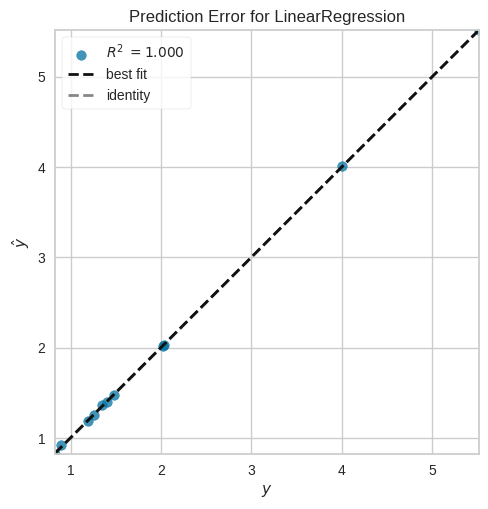

In [20]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=feature_exact_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
)

best_exact = s_exact.compare_models(turbo=True, sort=sort)
s_exact.plot_model(best_exact, plot="error")

## Regression with features from noiseless simulation

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 39)"
4,Transformed data shape,"(55, 38)"
5,Transformed train set shape,"(44, 38)"
6,Transformed test set shape,"(11, 38)"
7,Ignore features,1
8,Numeric features,37
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.2105,0.0745,0.2645,0.9457,0.0850,0.1173,0.0030
par,Passive Aggressive Regressor,0.2482,0.1149,0.3070,0.9171,0.0907,0.1291,0.0030
huber,Huber Regressor,0.2779,0.1383,0.3562,0.9071,0.1084,0.1486,0.0050
omp,Orthogonal Matching Pursuit,0.2986,0.1863,0.3916,0.8969,0.1100,0.1477,0.0040
et,Extra Trees Regressor,0.2925,0.2027,0.3967,0.8224,0.1219,0.1925,0.0100
ada,AdaBoost Regressor,0.3216,0.2059,0.4090,0.8799,0.1222,0.1791,0.0080
gbr,Gradient Boosting Regressor,0.3226,0.2369,0.4291,0.8908,0.1177,0.1488,0.0080
rf,Random Forest Regressor,0.3281,0.2545,0.4333,0.8758,0.1250,0.1665,0.0140
dt,Decision Tree Regressor,0.3980,0.2686,0.4778,0.7766,0.1497,0.2218,0.0040
ridge,Ridge Regression,0.4141,0.3707,0.5591,0.7968,0.1660,0.2605,0.0040


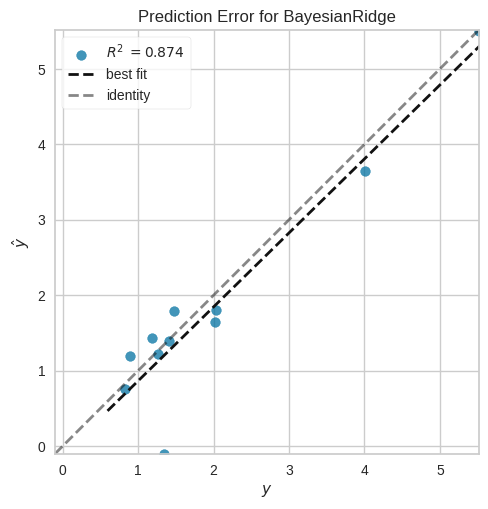

In [21]:
s_sim_noiseless = RegressionExperiment()
s_sim_noiseless.setup(
    data=feature_sim_noiseless_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
)

best_sim_noiseless = s_sim_noiseless.compare_models(turbo=True, sort=sort)
s_sim_noiseless.plot_model(best_sim_noiseless, plot="error")

## Regression with features from noisy simulation

In [22]:
def create_model_and_plot(
    experiment: RegressionExperiment,
    exact_experiment: RegressionExperiment,  # 比較用: non-Trotter シミュレータのノイズなしの結果
    sim_noiseless_experiment: RegressionExperiment,  # 比較用: Trotter シミュレータのノイズなしの結果
    reg_method=None,  # 回帰手法. "ada", "dt", "et", "gbr", "knn", "lar", "lightgbm", "lr", "mlp", "omp", "par", "ransac", "rf", "ridge", "svm", "xgboost"
) -> None:
    # モデルを作成
    if reg_method:  # 指定された回帰手法でモデルを作成
        model = experiment.create_model(reg_method, verbose=False)
        sim_model = sim_noiseless_experiment.create_model(reg_method, verbose=False)
    else:  # 指定されなければ最適なモデルを作成
        model = experiment.compare_models(turbo=True, sort=sort, verbose=False)
        sim_model = sim_noiseless_experiment.compare_models(
            turbo=True, sort=sort, verbose=False
        )

    # exact は最適なモデル (おそらく線形回帰) を作成
    exact_model = exact_experiment.compare_models(turbo=True, sort=sort, verbose=False)

    experiment.tune_model(model, optimize=sort, choose_better=True, verbose=False)
    exact_experiment.tune_model(
        exact_model, optimize=sort, choose_better=True, verbose=False
    )
    sim_noiseless_experiment.tune_model(
        sim_model, optimize=sort, choose_better=True, verbose=False
    )

    # 回帰手法の名前を取得
    reg_method = model.__class__.__name__
    exact_reg_method = exact_model.__class__.__name__
    sim_reg_method = sim_model.__class__.__name__

    # 予測
    pred = experiment.predict_model(model)
    x = pred["expected_value"].values.reshape(-1, 1)  # サンプル数 x 1
    y = pred["prediction_label"].values
    r2 = r2_score(x, y)
    mse = mean_squared_error(x, y)

    exact_pred = exact_experiment.predict_model(exact_model)
    exact_x = exact_pred["expected_value"].values.reshape(-1, 1)
    exact_y = exact_pred["prediction_label"].values
    exact_r2 = r2_score(exact_x, exact_y)
    exact_mse = mean_squared_error(exact_x, exact_y)

    sim_pred = sim_noiseless_experiment.predict_model(sim_model)
    sim_x = sim_pred["expected_value"].values.reshape(-1, 1)
    sim_y = sim_pred["prediction_label"].values
    sim_r2 = r2_score(sim_x, sim_y)
    sim_mse = mean_squared_error(sim_x, sim_y)

    # 回帰直線を計算
    linear_model = LinearRegression()
    linear_model.fit(x, y)
    slope = linear_model.coef_[0]
    intercept = linear_model.intercept_

    exact_linear_model = LinearRegression()
    exact_linear_model.fit(exact_x, exact_y)
    exact_slope = exact_linear_model.coef_[0]
    exact_intercept = exact_linear_model.intercept_

    sim_linear_model = LinearRegression()
    sim_linear_model.fit(sim_x, sim_y)
    sim_slope = sim_linear_model.coef_[0]
    sim_intercept = sim_linear_model.intercept_

    # プロット
    plt.figure(figsize=(8, 6))
    plt.scatter(
        x,
        y,
        alpha=0.5,
        color="green",
        label=f"{reg_method}, R2 = {r2:.2e}, MSE = {mse:.2e}",
    )
    plt.scatter(
        exact_x,
        exact_y,
        alpha=0.5,
        color="red",
        label=f"non-Trotter Sim: {exact_reg_method}, R2 = {exact_r2:.2e}, MSE = {exact_mse:.2e}",
    )
    plt.scatter(
        sim_x,
        sim_y,
        alpha=0.5,
        color="blue",
        label=f"Trotter Sim (noise free): {sim_reg_method}, R2 = {sim_r2:.2e}, MSE = {sim_mse:.2e}",
    )

    # 回帰直線を追加
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    plt.plot(
        x_range,
        linear_model.predict(x_range),
        color="green",
        label=f"Best fit line (y = {slope:.2e}x {'+' if intercept >= 0 else '-'} {abs(intercept):.2e})",
    )
    exact_x_range = np.linspace(exact_x.min(), exact_x.max(), 100).reshape(-1, 1)
    plt.plot(
        exact_x_range,
        exact_linear_model.predict(exact_x_range),
        color="red",
        label=f"non-Trotter Sim: Best fit line (y = {exact_slope:.2e}x {'+' if exact_intercept >= 0 else '-'} {abs(exact_intercept):.2e})",
    )
    sim_x_range = np.linspace(sim_x.min(), sim_x.max(), 100).reshape(-1, 1)
    plt.plot(
        sim_x_range,
        sim_linear_model.predict(sim_x_range),
        color="blue",
        label=f"Trotter Sim (noise free): Best fit line (y = {sim_slope:.2e}x {'+' if sim_intercept >= 0 else '-'} {abs(sim_intercept):.2e})",
    )

    # Identity line
    plt.plot(
        [x.min(), x.max()], [x.min(), x.max()], "--", color="black", label="Identity"
    )

    # if n_qubits == 4:
    #     plt.xlim([0.5, 4.5])
    #     plt.ylim([0.5, 4.5])
    # elif n_qubits == 8:
    #     plt.xlim([None, 16])
    #     plt.ylim([None, 16])
    # elif n_qubits == 12:
    #     plt.xlim([None, 10])
    #     plt.ylim([None, 10])

    # plt.rcParams["font.size"] = 16  # Docker だと反応しない？
    plt.tick_params(labelsize=12)
    plt.xlabel("Actual", fontsize=14)
    plt.ylabel("Predicted", fontsize=14)
    plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left", fontsize=14)
    plt.title(f"{n_qubits} qubits", fontsize=16)
    plt.savefig(f"results/analyze/regression_{n_qubits}qubits.pdf", bbox_inches="tight")
    plt.show()

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 39)"
4,Transformed data shape,"(55, 38)"
5,Transformed train set shape,"(44, 38)"
6,Transformed test set shape,"(11, 38)"
7,Ignore features,1
8,Numeric features,37
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.1066,0.0150,0.1226,0.9922,0.0533,0.0780


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0047,0.0001,0.0109,0.9999,0.0055,0.0046


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.3112,0.2434,0.4934,0.8739,0.2432,0.2152


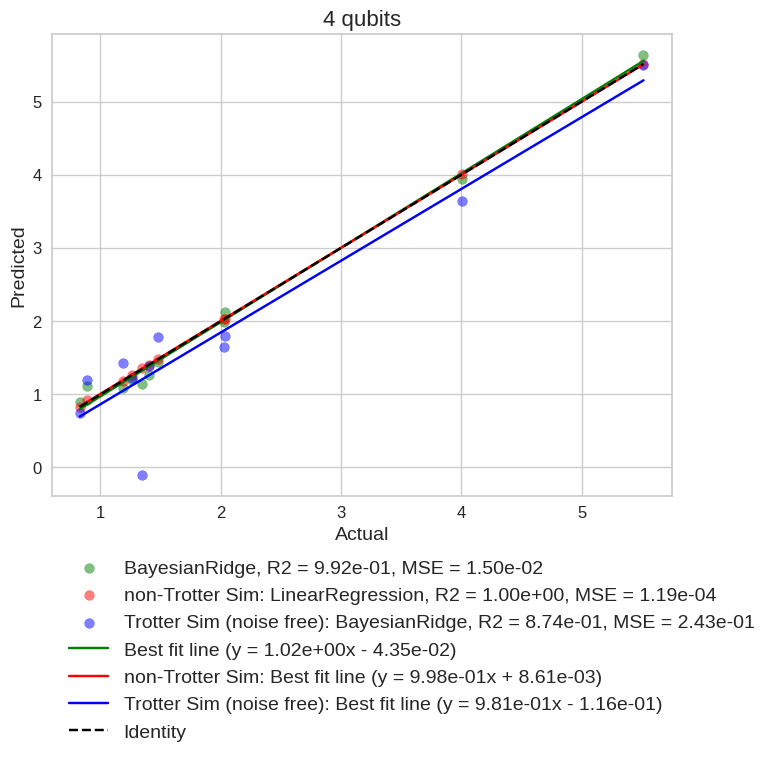

In [23]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=feature_sim_noisy_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
)
create_model_and_plot(s_sim_noisy, s_exact, s_sim_noiseless)

In [24]:
# これと同じ予測を上のセルでは行なっている
# best_sim_noisy = s_sim_noisy.compare_models(turbo=True, sort=sort)
# s_sim_noisy.plot_model(best_sim_noisy, plot="error")

## Regression with features from QPU

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 23)"
4,Transformed data shape,"(55, 22)"
5,Transformed train set shape,"(44, 22)"
6,Transformed test set shape,"(11, 22)"
7,Ignore features,2
8,Numeric features,21
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.4183,3.1641,1.7788,0.7463,0.4404,0.8251


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0025,0.0001,0.0078,1.0000,0.0036,0.0021


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.6386,0.6403,0.8002,0.9487,0.2231,0.3232


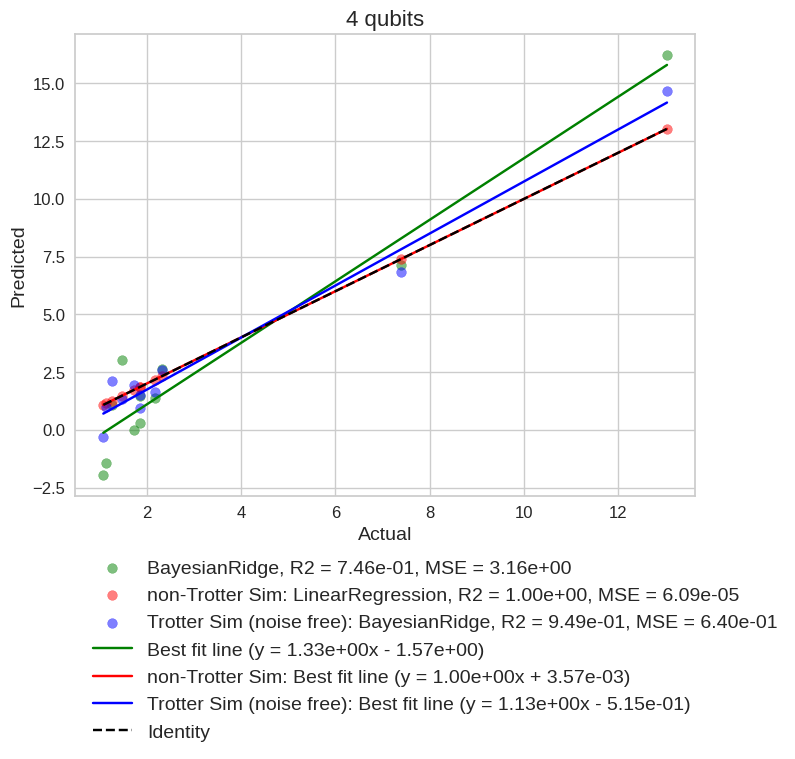

In [43]:
s_qpu = RegressionExperiment()
s_qpu.setup(
    data=feature_qpu_df,
    target="expected_value",
    ignore_features=["sample_id", "norm"],
    train_size=train_size,
    session_id=session_id,
)
create_model_and_plot(s_qpu, s_exact, s_sim_noiseless)

In [35]:
# これと同じ予測を上のセルでは行なっている
# best_nmit = s_nmit.compare_models(turbo=True, sort=sort)
# s_nmit.plot_model(best_nmit, plot="error")